# Test pipeline
1. Create dataset: sequence of preporcessed examples ready to feed to neuralnet 
2. Create dataloader: define how dataset is loaded to neuralnet (batch size, order, computation optimizing ...)
3. Create model : a bunch of matrixes math to transform input tensor to output tensor
4. Training loop:
    + Forward 
    + Calculate loss
    + Backward
    + Monitoring: 
        + Evaluate metrics
        + Logger, back and forth
        + Visualize

# Import necessary packages

In [1]:
import os
import glob
import sys
import random
import cv2

import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import wandb
from tqdm import tqdm
import numpy as np

from sklearn.model_selection import ShuffleSplit, train_test_split


# !pip install timm
# !pip install albumentations==0.4.6

import timm
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from pprint import pprint

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

%matplotlib inline


sys.path.insert(0, '..')
from src.models.utils import FaceDataset


In [2]:
hyperparameter_defaults = dict(
    dropout = 0.2,
    fc1 = 512,
    batch_size = 64,
    learning_rate = 0.005,
    epochs = 10,
    weight_decay = 0.001
)

wandb.init(config=hyperparameter_defaults, project='Age_Gender')

wandb: Currently logged in as: dyle_cse (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


# Create custom dataset

In [3]:
class CustomFaceDataset(FaceDataset):
    def __getitem__(self, idx):
        path = self.df.iloc[idx]["file_name"]
        age = self.df.iloc[idx]["age"].astype(np.float32)
        gender = self.df.iloc[idx]["gender"].astype(np.float32)
        
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('float32')
        img /= 255.0
        
        label_list = [age, gender]
        label_tensor = torch.tensor(label_list)
        
        if self.transform:
            img = self.transform(image = img)['image']
        
        return img, label_tensor

In [4]:
path2data = "/home/Data/"

df = pd.read_csv(path2data + "training_dataset.csv")

size = len(df)

val_size = 10000
test_size = 10000

train_df, test_df = train_test_split(df, test_size=test_size/size, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=val_size/len(train_df), random_state=42)

if not os.path.isdir(path2data + 'all'):
    os.makedirs(path2data + 'all')
    
train_df.to_csv(path2data + "all/training.csv", index=False, header=True)
val_df.to_csv(path2data + "all/val.csv",  index=False, header=True)
test_df.to_csv(path2data + "all/testing.csv",  index=False, header=True)

In [5]:
# create data set
path2data = "/home/Data/"

data_transform = A.Compose([ToTensorV2(p=1.0)])

train_ds = CustomFaceDataset(path2data + "all/training.csv", data_transform, None)
val_ds = CustomFaceDataset(path2data + "all/val.csv", data_transform, None)

print(len(train_ds))
print(len(val_ds))

181432
10000


# Create a transformer

In [8]:
meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in train_ds]
stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in train_ds]

meanR=np.mean([m[0] for m in meanRGB])
meanG=np.mean([m[1] for m in meanRGB])
meanB=np.mean([m[2] for m in meanRGB])

stdR=np.mean([s[0] for s in stdRGB])
stdG=np.mean([s[1] for s in stdRGB])
stdB=np.mean([s[2] for s in stdRGB])

print(meanR,meanG,meanB)
print(stdR,stdG,stdB)

0.54568475 0.42776844 0.3761094
0.21924357 0.18996198 0.17315607


In [6]:
meanR,meanG,meanB = 0.54568475 ,0.42776844 ,0.3761094
stdR,stdG,stdB = 0.21924357, 0.18996198, 0.17315607
 
def get_train_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Resize(224, 224),
        A.Cutout(num_holes=4, max_h_size=4, max_w_size=4, fill_value=0, always_apply=False, p=0.5),
        A.Normalize(mean=(meanR,meanG,meanB), std=(stdR,stdG,stdB)),
        ToTensorV2(),
    ])

def get_val_transforms():
    return A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(meanR,meanG,meanB), std=(stdR,stdG,stdB)),
        ToTensorV2(),
    ])

In [7]:
train_ds.transform = get_train_transforms()
val_ds.transform = get_val_transforms()

# Create Data loader

In [6]:
import matplotlib.pyplot as plt
def show(img,label=None):
    npimg = img.numpy().transpose((1,2,0))
    plt.imshow(npimg)
    if label is not None:
        label = label.view(-1,2)
        for point in label:
            x,y= point
            plt.plot(x,y,'b+',markersize=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


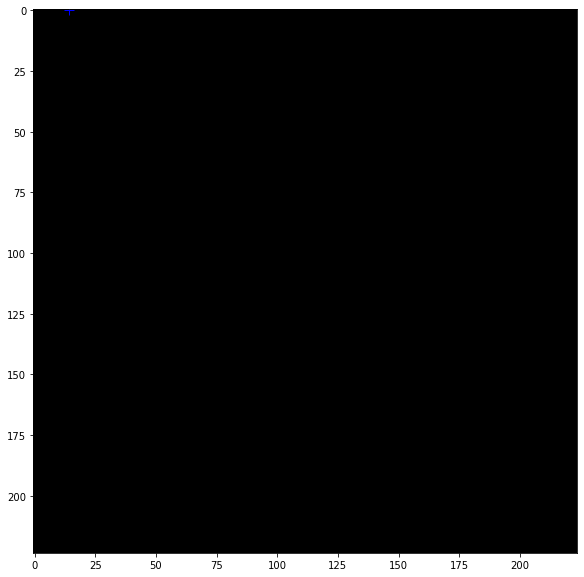

In [7]:
plt.figure(figsize=(10,10))
for img,label in train_ds:
    show(img,label)
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


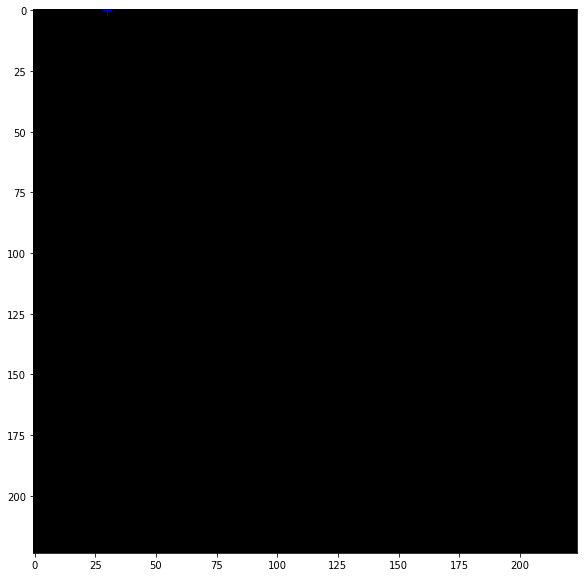

In [8]:
plt.figure(figsize=(10,10))
for img,label in val_ds:
    show(img,label)
    break

In [8]:
from torch.utils.data import DataLoader

train_dl = DataLoader(
    train_ds, 
    batch_size = wandb.config.batch_size, 
    num_workers=4,
    shuffle=True
)

val_dl = DataLoader(
    val_ds, 
    batch_size = 256, 
    num_workers=4,
    shuffle=False
)

In [13]:
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(label_b.shape)
    break

torch.Size([64, 3, 224, 224]) torch.float32
torch.Size([64, 2])


In [14]:
for img, label in val_dl:
    print(label.shape)
    break

torch.Size([256, 2])



# Create Model

In [13]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
    def forward(self, x):
        return x

In [14]:
def __init__(self, params):
    super(Net, self).__init__()
    
    C_in,H_in,W_in=params["input_shape"] 
    self.dropout_rate=params["drop_rate"] 
    self.num_fc1 = params["num_fc1"]
    self.is_freeze = params['is_freeze']
    
    mobile_v3 =  timm.create_model('mobilenetv3_large_100', pretrained=True)
    
    in_features = mobile_v3.classifier.in_features
    
    mobile_v3.classifier = nn.Linear(in_features, self.num_fc1)
    
    self.backbone = nn.Sequential(
                    mobile_v3,
                    nn.BatchNorm1d(num_features=self.num_fc1),
                    nn.ReLU()
    )
    
    self.gender_head = nn.Sequential(
                            nn.Dropout(p=self.dropout_rate),
                            nn.Linear(self.num_fc1, 1),
                            nn.Sigmoid()
    )
    
    self.age_head = nn.Sequential(
                    nn.Linear(self.num_fc1, 1)
    )
    
    if self.is_freeze:
        for param in self.backbone.parameters():
            param.requires_grad = False

In [15]:
def forward(self, x):
    x = self.backbone(x)  
    
    gender = self.gender_head(x)
    age = self.age_head(x)
    
    return age, gender

In [16]:
Net.__init__= __init__
Net.forward = forward

params_model={
        "input_shape": (3,224,224),
        "drop_rate" : wandb.config.dropout,
        "num_fc1" : wandb.config.fc1,
        "is_freeze" : True
            }

model = Net(params_model)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

device = torch.device("cuda")
model = model.to(device)

wandb.watch(model)

Let's use 4 GPUs!


# Create optimizer

In [17]:
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# param_optimizer = list(model.named_parameters())
# no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
# optimizer_grouped_parameters = [
#     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': wandb.config.weight_decay},
#     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
# ] 

# opt = optim.Adam(optimizer_grouped_parameters, lr=wandb.config.learning_rate)
opt = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=2,verbose=1)

# Create custom Performance

In [18]:
from src.models import experiment
from src.models.experiment import Performance

class CustomPerformance(Performance):
    def __init__(self):
        Performance.__init__(self)
        self.gender_loss_func = nn.BCELoss(reduction="sum")
        self.age_loss_func = nn.MSELoss(reduction="sum")
        
    def loss_function(self, predictions, targets):
        age, gender = predictions
        gender_targets = targets[:, 1].unsqueeze(1)
        age_targets = targets[:, 0].unsqueeze(1)
        
        loss_age = self.age_loss_func(age, age_targets)
        
        loss_gender = self.gender_loss_func(gender, gender_targets)
        
        loss = loss_age + loss_gender
        
        return loss, loss_age, loss_gender

    def metrics_function(self, predictions, targets):
        age, gender = predictions
        gender_targets = targets[:, 1].unsqueeze(1)
        age_targets = targets[:, 0].unsqueeze(1)
        
        gender = gender > 0.5
        acc_gender = (gender == gender_targets).sum()
        
        mae_age = torch.abs(age - age_targets).sum()
        
        return torch.tensor([acc_gender, mae_age])


# Training

In [19]:
class AverageMeter:
    def __init__(self):
        self.sum = 0.0
        self.count = 0.0

    def update(self, val, n):
        self.sum += val
        self.count += n

    def get_avg(self):
        return self.sum / self.count


classes = ('female', 'male')

class CustomPipeline(experiment.Pipeline):
    def _process_epoch(self, training):
        loss_monitor = AverageMeter()
        loss_age_monitor = AverageMeter()
        loss_gender_monitor = AverageMeter()
        metrics_monitor = AverageMeter()
        if training:
            dataset_dl = self.train_dl
        else:
            dataset_dl = self.val_dl

        for xb, yb in tqdm(dataset_dl, total=len(dataset_dl), desc='Progress'):
            yb=yb.to(self.params.device)

            # get model output
            predictions = self.model(xb.to(self.params.device))

            # get loss per batch
            loss, loss_age, loss_gender = self.performance.loss_function(predictions, yb)
            
            loss_age_monitor.update(loss_age, len(yb))
            loss_gender_monitor.update(loss_gender, len(yb))
            loss_monitor.update(loss, len(yb))

            # get metrcis per batch
            metrics = self.performance.metrics_function(predictions, yb)
            metrics_monitor.update(metrics, len(yb))

            if training:
                wandb.log({'Train Loss': loss_monitor.get_avg(), 'Train loss age' : loss_age_monitor.get_avg(), 'Train loss gender' : loss_gender_monitor.get_avg(), 'Train Accuracy': metrics_monitor.get_avg()[0], 'Train MAE' : metrics_monitor.get_avg()[1]})
                    
            else:               
                dataiter = iter(dataset_dl)
                images, labels = dataiter.next()[:20]
                images, labels = images.to(self.params.device), labels.to(self.params.device)
                
                outputs = self.model(images)
               
                _, gender_b = outputs
                gender_b = gender_b > 0.5
                
                example_images = [wandb.Image(image, caption=classes[gender])
                                  for image, gender, label in zip(images, gender_b, labels[:, 1])]
                
                wandb.log({'Example' : example_images, 'Val Loss': loss_monitor.get_avg(), 'Val Accuracy': metrics_monitor.get_avg()[0], 'Val MAE' : metrics_monitor.get_avg()[1]})
            
            # update parameters
            if training:
                self.params.opt.zero_grad()
                loss.backward()
                self.params.opt.step()  

            if self.params.sanity_check:
                break

        return loss_monitor, metrics_monitor
    
    def test(self, test_dl):          
        # evaluate the model    
        loss_monitor = AverageMeter()
        metrics_monitor = AverageMeter()
        self.model.eval()

        with torch.no_grad():
            for xb, yb in tqdm(test_dl, total = len(test_dl), desc='Progress'):
                yb=yb.to(self.params.device)

                # get model output
                predictions = self.model(xb.to(self.params.device))

                # get loss per batch
                loss, _, _ = self.performance.loss_function(predictions, yb)
                loss_monitor.update(loss, len(yb))

                # get metrcis per batch
                metrics = self.performance.metrics_function(predictions, yb)
                metrics_monitor.update(metrics, len(yb))

        return loss_monitor.get_avg(), metrics_monitor.get_avg()      

In [20]:
root_logdir = '../models'

def get_run_logdir():
    import time
    run_id = time.strftime("exp_%Y_%m_%d-%H_%M_%S")
    if not os.path.isdir(os.path.join(root_logdir, run_id)):
        os.makedirs(os.path.join(root_logdir, run_id))
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [21]:
run_logdir

'../models/exp_2020_12_09-16_51_29'

In [22]:
performance = CustomPerformance()

path2models= os.path.join(run_logdir, 'best_checkpoints.bin')
params = experiment.Prams(num_epochs=wandb.config.epochs, path2weights=path2models, device=device,optimizer=opt, lr_scheduler=lr_scheduler, sanity_check=False)

pipeline = CustomPipeline(model, train_dl, val_dl, performance, params)
model, performance = pipeline.train_val()

Progress:   0%|          | 0/2835 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.005


Progress:   0%|          | 0/2835 [00:00<?, ?it/s]

Copied best model weights!
train loss: 100.064713, time: 5.40814
val loss: 209.435867, time: 1.92706
----------
Epoch 1/9, current lr=0.005


Progress:   0%|          | 0/2835 [00:00<?, ?it/s]

Copied best model weights!
train loss: 94.947090, time: 5.26162
val loss: 124.493408, time: 1.90730
----------
Epoch 2/9, current lr=0.005


Progress:   0%|          | 0/2835 [00:00<?, ?it/s]

Copied best model weights!
train loss: 94.464935, time: 5.21712
val loss: 95.167793, time: 1.92494
----------
Epoch 3/9, current lr=0.005


Progress:   0%|          | 0/2835 [00:00<?, ?it/s]

train loss: 94.062485, time: 5.21927
val loss: 114.465958, time: 1.94874
----------
Epoch 4/9, current lr=0.005


Progress:   0%|          | 0/2835 [00:00<?, ?it/s]

train loss: 93.675781, time: 5.43589
val loss: 105.774536, time: 1.98077
----------
Epoch 5/9, current lr=0.005


Progress:   0%|          | 0/2835 [00:00<?, ?it/s]

Epoch     6: reducing learning rate of group 0 to 2.5000e-03.
Loading best model weights!
train loss: 93.448608, time: 5.42314
val loss: 134.776596, time: 2.01009
----------
Epoch 6/9, current lr=0.0025


Progress:   0%|          | 0/2835 [00:00<?, ?it/s]

Copied best model weights!
train loss: 93.617569, time: 5.46677
val loss: 93.290245, time: 2.00197
----------
Epoch 7/9, current lr=0.0025


Progress:   0%|          | 0/2835 [00:00<?, ?it/s]

train loss: 93.370514, time: 5.41569
val loss: 126.611031, time: 2.02300
----------
Epoch 8/9, current lr=0.0025


Progress:   0%|          | 0/2835 [00:00<?, ?it/s]

Copied best model weights!
train loss: 93.304169, time: 5.42897
val loss: 92.854607, time: 2.04143
----------
Epoch 9/9, current lr=0.0025


Progress: 100%|██████████| 40/40 [02:03<00:00,  3.08s/it]


train loss: 93.085304, time: 5.42046
val loss: 95.519188, time: 2.06128
----------


In [23]:
loss_hist, metrics_history = performance.loss_history, performance.metrics_history
train_hist = torch.stack(metrics_history["train"])
val_hist = torch.stack(metrics_history["val"])

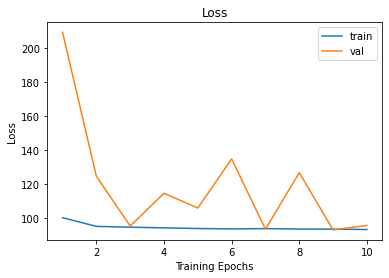

In [24]:
# Train-Validation Progress

# plot loss progress
plt.title("Loss")
plt.plot(range(1,wandb.config.epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,wandb.config.epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

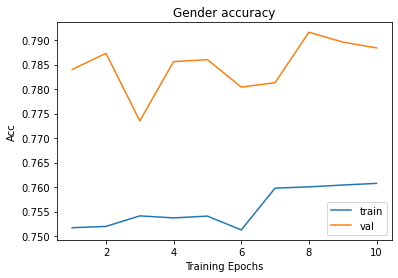

In [25]:
# plot accuracy progress
plt.title("Gender accuracy")
plt.plot(range(1,wandb.config.epochs+1),train_hist[:,0], label="train")
plt.plot(range(1,wandb.config.epochs+1),val_hist[:,0],label="val")
plt.ylabel("Acc")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

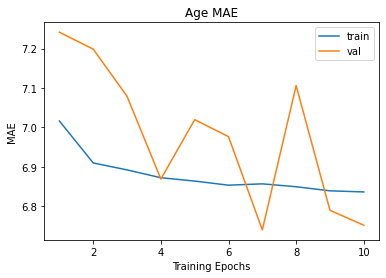

In [26]:
# plot accuracy progress
plt.title("Age MAE")
plt.plot(range(1,wandb.config.epochs+1),train_hist[:,1], label="train")
plt.plot(range(1,wandb.config.epochs+1),val_hist[:,1],label="val")
plt.ylabel("MAE")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# Testing

In [27]:
performance = CustomPerformance()

path2models= os.path.join(run_logdir, 'best_checkpoints.bin')
params = experiment.Prams(num_epochs=wandb.config.epochs, path2weights=path2models, device=device, optimizer=opt, lr_scheduler=lr_scheduler, sanity_check=False)

best_pipeline = CustomPipeline(model, train_dl, val_dl, performance, params)

best_pipeline.load(path2models)

best_model = best_pipeline.model

In [28]:
test_ds = CustomFaceDataset(path2data + "all/testing.csv", get_val_transforms(), None)

In [29]:
test_dl = DataLoader(test_ds, batch_size = wandb.config.batch_size, num_workers = 4, shuffle=False)

In [30]:
loss_test, metrics_test = best_pipeline.test(test_dl)

Progress: 100%|██████████| 157/157 [00:13<00:00, 11.41it/s]


In [31]:
# Gender Accuracy
print(max(train_hist[:,0]))
print(max(val_hist[:,0]))
print(metrics_test[0])

tensor(0.7607)
tensor(0.7916)
tensor(0.8009)


In [32]:
# Age MAE
print(min(train_hist[:,1]))
print(min(val_hist[:,1]))
print(metrics_test[1])

tensor(6.8362)
tensor(6.7398)
tensor(6.7196)


In [33]:
# Loss
print(min(loss_hist["train"]))
print(min(loss_hist["val"]))
print(loss_test)

tensor(93.0853, device='cuda:0', grad_fn=<DivBackward0>)
tensor(92.8546, device='cuda:0')
tensor(91.5587, device='cuda:0')


In [34]:
summary(model, (3, 224, 224), device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
            Conv2d-2         [-1, 16, 112, 112]             432
       BatchNorm2d-3         [-1, 16, 112, 112]              32
       BatchNorm2d-4         [-1, 16, 112, 112]              32
       HardSwishMe-5         [-1, 16, 112, 112]               0
       HardSwishMe-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             144
            Conv2d-8         [-1, 16, 112, 112]             144
       BatchNorm2d-9         [-1, 16, 112, 112]              32
      BatchNorm2d-10         [-1, 16, 112, 112]              32
             ReLU-11         [-1, 16, 112, 112]               0
             ReLU-12         [-1, 16, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             256
           Conv2d-14         [-1, 16, 1